In [1]:
import os
os.chdir("../../")
os.getcwd()

'/home/yeonwoo/study'

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [4]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-2024-08-06")
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


In [6]:
agent_executor.invoke({"messages": [("user", "who is the winnner of 2024 League of legend world champion ship")]})

{'messages': [HumanMessage(content='who is the winnner of 2024 League of legend world champion ship', additional_kwargs={}, response_metadata={}, id='b1e85700-65b4-44df-b670-81ca546fb411'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uG5iPNR1YtaMOVrW1xExJcPs', 'function': {'arguments': '{"query":"2024 League of Legends World Championship winner"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 101, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fa304a2a-225f-458b-992d-25fe44af39ce-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'

In [7]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [8]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [9]:
# planning step

from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """주어진 목표에 대해 간단한 단계별 계획을 세우십시오. \
이 계획에는 개별 작업이 포함되어야 하며 올바르게 실행되면 정답이 나올 것입니다. 불필요한 단계를 추가하지 마십시오. \
마지막 단계의 결과가 최종 답이 되어야 합니다. 각 단계에 필요한 모든 정보가 포함되어 있는지 확인하세요. 단계를 건너뛰지 마세요.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-2024-08-06", temperature=0
).with_structured_output(Plan)

In [11]:
planner.invoke(
    {
        "messages": [
            ("user", "who is the winnner of 2024 League of legend world champion ship")
        ]
    }
)

Plan(steps=['Check the official League of Legends website or trusted esports news sources for the latest updates on the 2024 World Championship.', 'Look for the announcement or article that declares the winner of the 2024 League of Legends World Championship.', 'Verify the information from multiple sources to ensure accuracy.', 'Note down the name of the winning team.'])

In [12]:
## replan
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """주어진 목표에 대해 간단한 단계별 계획을 세우십시오. \
이 계획에는 개별 작업이 포함되어야 하며 올바르게 실행되면 정답이 나올 것입니다. 불필요한 단계를 추가하지 마십시오. \
마지막 단계의 결과가 최종 답이 되어야 합니다. 각 단계에 필요한 모든 정보가 포함되어 있는지 확인하세요. 단계를 건너뛰지 마세요.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

그에 따라 계획을 업데이트하세요. 더 이상 단계가 필요하지 않고 사용자에게 돌아갈 수 있으면 이에 대해 응답하세요. 그렇지 않으면 계획을 작성하십시오. 아직 완료해야 하는 단계만 계획에 추가하세요. 계획의 일부로 이전에 수행한 단계를 반환하지 마세요."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-2024-08-06", temperature=0
).with_structured_output(Act)

In [13]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [14]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

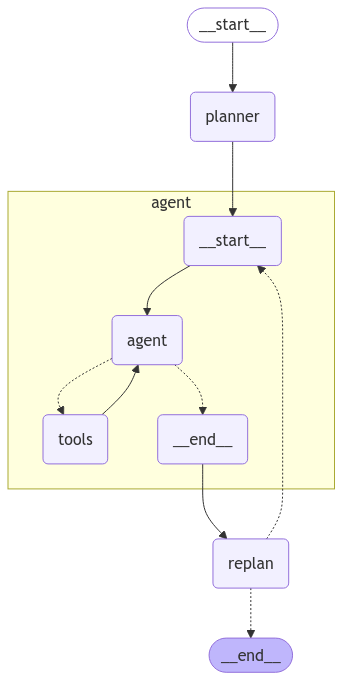

In [15]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [20]:
config = {"recursion_limit": 50}
inputs = {"input": "경희대학교 모든학과의 2024년 수시 등급컷을 markdown table 형태로 markdown table만 제공해줘"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Access the official Kyung Hee University admissions website.', 'Navigate to the section for 2024 admissions information.', 'Locate the specific page or document that lists the admission grade cutoffs for all departments for the 2024 academic year.', "Extract the relevant data for each department's admission grade cutoff.", 'Format the extracted data into a markdown table with columns for Department and Grade Cutoff.', 'Ensure the table is correctly formatted and contains all necessary information.']}
{'past_steps': [('Access the official Kyung Hee University admissions website.', 'The official Kyung Hee University admissions website can be accessed via the following URL: [Kyung Hee University Admissions](https://iadmission.khu.ac.kr/gglobalcenter/user/contents/view.do?menuNo=8000031).')]}
{'plan': ['Navigate to the section for 2024 admissions information on the Kyung Hee University admissions website.', 'Locate the specific page or document that lists the admission grade cut